Copyright 2023 Roland S. Zimmermann

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Fooling Feature Visualizations Through Orthogonal Filters

In [ ]:
# This notebook requires a custom version of lucent,
# which has more features than the one on PyPI and follows
# the original lucid library more closely:
%pip install git+https://github.com/zimmerrol/lucent.git

In [1]:
from typing import Callable, Dict, Union, Literal, List, Tuple

import os
import gc

import numpy as np
import torch
from torch import nn
from torchvision import models
from torchvision.models import resnet
from tqdm.notebook import tqdm as tqdm
from matplotlib import pyplot as plt

# Attention: This requires a specific version of lucent
# (i.e., an still actively-developed fork): https://github.com/zimmerrol/lucent
import lucent
import lucent.modelzoo
import lucent.modelzoo.util
from lucent.optvis.hooks import ModelHook
from lucent.optvis import render
from lucent.optvis import param

# Use FFCV for quick data loading.
from pathlib import Path
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import ToTensor, ToDevice, Squeeze, NormalizeImage, ToTorchImage
from ffcv.fields.rgb_image import CenterCropRGBImageDecoder
from ffcv.fields.basics import IntDecoder
from torch.cuda.amp import autocast

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"

# Utils

## Model Utils

In [3]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x


class BottleneckFooling(nn.Module):
    """Bottleneck block of the ResNet architecture with fooling units."""

    def __init__(self, base: resnet.Bottleneck) -> None:
        super().__init__()
        self.conv1 = duplicate_conv(base.conv1, bias=False)
        self.bn1 = duplicate_norm(base.bn1)
        self.conv2 = duplicate_conv(base.conv2, bias=False)
        self.bn2 = duplicate_norm(base.bn2)
        self.conv3 = duplicate_conv(base.conv3, bias=False)
        self.bn3 = duplicate_norm(base.bn3)
        self.relu1 = nn.ReLU(inplace=False)
        self.relu2 = nn.ReLU(inplace=False)
        self.relu3 = nn.ReLU(inplace=False)
        self.relu1_fooling = nn.ReLU(inplace=False)
        self.relu2_fooling = nn.ReLU(inplace=False)
        self.relu3_fooling = nn.ReLU(inplace=False)
        self.conv1_fooling = duplicate_conv(self.conv1, bias=True)
        self.conv2_fooling = duplicate_conv(self.conv2, bias=True)
        self.conv3_fooling = duplicate_conv(self.conv3, bias=True)

        self.conv1_fooling_merge = identity_conv(self.conv1)
        self.conv2_fooling_merge = identity_conv(self.conv2)
        self.conv3_fooling_merge = identity_conv(self.conv3)

        self.downsample = base.downsample

        self.identity = Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.identity(x)

        out_fooling = self.conv1_fooling(x)
        out_fooling = self.relu1_fooling(out_fooling)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv1_fooling_merge(torch.cat((out, out_fooling), 1))

        out_fooling = self.conv2_fooling(out)
        out_fooling = self.relu2_fooling(out_fooling)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2_fooling_merge(torch.cat((out, out_fooling), 1))

        out_fooling = self.conv3_fooling(out)
        out_fooling = self.relu3_fooling(out_fooling)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.conv3_fooling_merge(torch.cat((out, out_fooling), 1))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)

        return out


def duplicate_conv(module: nn.Module, bias: bool = True, overwrite_values: Dict = {}):
    """Duplicate a convolutional layer.

    Args:
        module: The convolutional layer to duplicate.
        bias: Whether to duplicate the bias.
        overwrite_values: Values to overwrite in the new layer.

    Returns:
        The duplicated layer.
    """
    kw = (
        "in_channels",
        "out_channels",
        "kernel_size",
        "stride",
        "padding",
        "dilation",
        "groups",
        "padding_mode",
    )
    kwargs = {k: getattr(module, k) for k in kw}
    kwargs = {**kwargs, **overwrite_values}
    return type(module)(**kwargs, bias=bias)


def duplicate_norm(module: nn.Module):
    """Duplicate a normalization layer.

    Args:
        module: The normalization layer to duplicate.

    Returns:
        The duplicated layer.
    """
    kw = ("num_features", "eps", "momentum")
    return type(module)(**{k: getattr(module, k) for k in kw})


def identity_conv(previous_conv: nn.Module) -> nn.Module:
    """Create a convolutional layer that acts as the identity function.

    Args:
        previous_conv: The convolutional layer to create an identity layer
        for (i.e., the previous layer).
    """
    n = previous_conv.weight.data.shape[0]
    m = nn.Conv2d(2 * n, n, 3, padding=1, bias=False)
    m.weight.data.zero_()
    m.weight.data[np.arange(n), np.arange(n), 1, 1] = 1.0

    return m


def replace_module(
    model: nn.Module,
    check_fn: Callable[[nn.Module], bool],
    get_replacement_fn: Callable[[nn.Module], nn.Module],
) -> None:
    """Replace all modules in a model that satisfy a condition.

    Args:
        model: The model to replace modules in.
        check_fn: A function that takes a module and returns whether it should
        be replaced.
        get_replacement_fn: A function that takes a module and returns a
        replacement module.
    """
    children = list(model.named_children())
    for name, value in children:
        if check_fn(value):
            new_value = get_replacement_fn(value)
            setattr(model, name, new_value)
        replace_module(value, check_fn, get_replacement_fn)


def reset_fooling_units(model: nn.Module) -> None:
    """Reset the weights of the fooling units in a model.

    Args:
        model: The model to reset the fooling units of.
    """
    for value in model.modules():
        if isinstance(value, BottleneckFooling):
            for l in (value.conv1_fooling, value.conv2_fooling, value.conv3_fooling):
                l.weight.data.zero_()
                l.bias.data.zero_()

## Fooling Utils

In [4]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406]) * 255
IMAGENET_STD = np.array([0.229, 0.224, 0.225]) * 255
DEFAULT_CROP_RATIO = 224 / 256

INCEPTION_MEAN = np.ones(3) * 127
INCEPTION_STD = np.ones(3)


def create_val_loader(
    in_val_dataset: str,
    num_workers: int,
    batch_size: int,
    resolution: int,
    distributed: bool,
    normalization_mode: Union[Literal["imagenet"], Literal["inception"]] = "imagenet",
) -> Loader:
    """Create a dataloader of the ImageNet validation dataset.

    Args:
        in_val_dataset: The path to the ImageNet validation dataset.
        num_workers: The number of workers to use for loading the dataset.
        batch_size: The batch size to use for loading the dataset.
        resolution: The resolution to load the images at.
        distributed: Whether to use distributed training.
        normalization_mode: The normalization mode to use for the images.
    """
    this_device = device
    val_path = Path(in_val_dataset)
    assert val_path.is_file()
    res_tuple = (resolution, resolution)
    cropper = CenterCropRGBImageDecoder(res_tuple, ratio=DEFAULT_CROP_RATIO)
    image_pipeline = [
        cropper,
        ToTensor(),
        ToDevice(torch.device(this_device), non_blocking=True),
        ToTorchImage(),
    ]

    if normalization_mode == "imagenet":
        image_pipeline.append(NormalizeImage(IMAGENET_MEAN, IMAGENET_STD, np.float16))
        print("Using imagenet normalization.")
    elif normalization_mode == "inception":
        image_pipeline.append(NormalizeImage(INCEPTION_MEAN, INCEPTION_STD, np.float16))
        print("Using inception normalization.")
    else:
        raise ValueError(f"Unknown normalization mode {normalization_mode}")

    label_pipeline = [
        IntDecoder(),
        ToTensor(),
        Squeeze(),
        ToDevice(torch.device(this_device), non_blocking=True),
    ]

    loader = Loader(
        in_val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        order=OrderOption.SEQUENTIAL,
        drop_last=False,
        pipelines={"image": image_pipeline, "label": label_pipeline},
        distributed=distributed,
    )
    return loader

In [5]:
def get_features(
    model: nn.Module, layers: List[str], loader: Loader
) -> List[np.ndarray]:
    """Get intermediate features of a model on natural images.

    Args:
        model: The model to get features of.
        layers: The layers to get features of.
        loader: The loader to use for loading images.

    Returns:
        A list of features for each layer.
    """
    features = []

    with ModelHook(model, layer_names=layers) as hook:
        with torch.no_grad():
            with autocast():
                for x, y in tqdm(loader, leave=False):
                    model(x)
                    features.append(
                        {layer: hook(layer).cpu().numpy() for layer in layers}
                    )

    features = [np.concatenate([f[layer] for f in features]) for layer in layers]

    return features

In [6]:
def find_maximally_activating_cnn_filter(
    model: nn.Module,
    upstream_layer_name: str,
    downstream_layer_name: str,
    downstream_filter_index: int,
    target_img: torch.Tensor,
    n_steps: int = 10000,
    verbose: bool = False,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Find a maximally activating CNN filter.

    Args:
        model: The model to find the filter for.
        upstream_layer_name: The name of the layer to find the filter for.
        downstream_layer_name: The name of the layer to find the filter for.
        downstream_filter_index: The index of the filter to find the filter for.
        img: The target input image.
        n_steps: The number of optimization steps to use.
        verbose: Whether to print progress.

    Returns:
        The maximally activating filter, the activation of the filter, and the
        bias of the filter.
    """

    assert target_img.ndim == 3
    target_img = target_img.unsqueeze(0)
    with torch.no_grad():
        with render.ModelHook(model) as hook:
            model(target_img)
            activation = hook(upstream_layer_name)
            downstream_activation = hook(downstream_layer_name)[
                :, downstream_filter_index
            ]

    downstream_unit = lucent.modelzoo.util.get_model_layer(model, downstream_layer_name)
    unit = duplicate_conv(
        downstream_unit, bias=False, overwrite_values={"out_channels": 1}
    ).to(activation.device)

    optimizer = torch.optim.SGD(unit.parameters(), lr=1e-3)
    if verbose:
        pbar = tqdm(range(n_steps))
    else:
        pbar = range(n_steps)

    for _ in pbar:
        optimizer.zero_grad()
        out = unit(activation)
        channel_activation = out.sum()
        loss = -channel_activation
        loss.backward()
        optimizer.step()

        unit.weight.data = (
            unit.weight.data / torch.norm(unit.weight.data.view(-1), keepdim=True)
        ).detach()

        if verbose:
            pbar.set_postfix_str(f"Activation: {channel_activation.item():.4f}")

    return (
        unit.weight.data.detach()[0],
        downstream_activation,
        downstream_unit.bias.data[downstream_filter_index].detach()
        if downstream_unit.bias
        else torch.zeros((1,), device=target_img.device),
    )

In [7]:
def orthogonalize(x: torch.Tensor, base: torch.Tensor) -> torch.Tensor:
    """Orthogonalize x with respect to base.

    Args:
        x: The vector to orthogonalize.
        base: The base to orthogonalize with respect to.

    Returns:
        The orthogonalized vector.
    """
    return x - torch.dot(base.flatten(), x.flatten()) * base / torch.dot(
        base.flatten(), base.flatten()
    )


def init_fooling_unit(
    model: nn.Module,
    layer_name: str,
    fooling_layer_name: str,
    merge_layer_name: str,
    filter_indices: int,
    delta_ws: torch.Tensor,
    features: torch.Tensor,
    lbd: float = 1.0,
    natural_activation_levels=None,
    weight_factor: float = 1,
) -> None:
    """Initialize a fooling unit.

    Args:
        model: The model to initialize the fooling unit of.
        layer_name: The name of the layer to initialize the fooling unit of.
        fooling_layer_name: The name of the fooling layer.
        merge_layer_name: The name of the merge layer.
        filter_indices: The indices of the filters to initialize.
        delta_ws: The delta weights to use for initialization.
        features: The features to use for initialization.
        lbd: The lambda to use for initialization.
        natural_activation_levels: The natural activation levels to use for
        initialization.
        weight_factor: The weight factor to use for initialization.
    """
    unit = lucent.modelzoo.util.get_model_layer(model, layer_name)
    fooling_unit = lucent.modelzoo.util.get_model_layer(model, fooling_layer_name)
    merge_unit = lucent.modelzoo.util.get_model_layer(model, merge_layer_name)

    bs = []
    w_news = []
    for idx, filter_index in tqdm(
        enumerate(filter_indices), leave=False, desc="Setting weights and biases"
    ):
        w = unit.weight.data[filter_index]

        delta_w = delta_ws[idx]

        delta_w = orthogonalize(delta_w, w)
        delta_w = delta_w / torch.sum(delta_w**2) * torch.sum(w**2)
        assert torch.all(
            torch.abs(torch.dot(delta_w.flatten(), w.flatten())) < 1e-4
        ), torch.dot(delta_w.flatten(), w.flatten())

        w_new = w + lbd * delta_w
        w_new = w_new / torch.sum(w_new**2) * torch.sum(w**2)
        w_new *= weight_factor

        w_news.append(w_new)

        if unit.bias is None:
            b = torch.zeros((1,), device=w.device)
        else:
            b = unit.bias.data[filter_index]

        bs.append(b)

    w_news = torch.stack(w_news, 0)
    bs = torch.stack(bs, 0)

    if natural_activation_levels is None:
        max_natural_activation_levels = None
    else:
        max_natural_activation_levels = torch.tensor(natural_activation_levels)
    batch_size = 128
    for start_idx in tqdm(
        range(0, len(features), batch_size),
        leave=False,
        desc="Determining necessary bias offset",
    ):
        with torch.no_grad():
            with autocast():
                inp = torch.tensor(
                    features[start_idx : start_idx + batch_size],
                    device=device,
                    dtype=torch.float16,
                )
                res = torch.nn.functional.conv2d(inp, w_news)
                res = res.max(3)[0].max(2)[0]
                if max_natural_activation_levels is None:
                    max_natural_activation_levels = res.max(0)[0].cpu()
                else:
                    max_natural_activation_levels = torch.maximum(
                        res.max(0)[0].cpu(), max_natural_activation_levels
                    )

    delta_bs = -max_natural_activation_levels.to(bs.device)
    bs = bs[:, 0]
    b_news = bs + delta_bs

    fooling_unit.weight.data = w_news.detach()
    fooling_unit.bias.data = b_news.detach()

    n_filters = fooling_unit.weight.shape[0]

    merge_unit.weight.data.zero_()

    for filter_index in filter_indices:
        merge_unit.weight.data[filter_index, n_filters + filter_index, 1, 1] = 1.0
        merge_unit.weight.data[filter_index, filter_index, 1, 1] = 1.0

# Create ResNet with near-identical FVs

In [8]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_fooled = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

replace_module(
    model_fooled,
    lambda x: isinstance(x, resnet.Bottleneck),
    lambda x: BottleneckFooling(x),
)
reset_fooling_units(model_fooled)

missing_keys = model_fooled.load_state_dict(
    model.state_dict(), strict=False
).missing_keys
for k in missing_keys:
    if "_fooling" not in k:
        raise ValueError(f"Truly missing key: {k}.")

model = model.eval().to(device)
model_fooled = model_fooled.eval().to(device)

In [9]:
# The ffcv/baton file is a preprocessed version of the ImageNet validation
# dataset, following the instructions given in https://github.com/libffcv/ffcv-imagenet
val_loader = create_val_loader(
    os.path.expandvars("$SCRATCH/datasets/ffcv_imagenet_data/val_500_0.50_90.ffcv"),
    8,
    160,
    224,
    0,
    "imagenet",
)

# Either apply this to all residual blocks:
# blocks_of_interest = list(filter(lambda x: len(x.split("_")) == 2, lucent.modelzoo.util.get_model_layers(model)))
# Or just to a single block:
blocks_of_interest = ["layer4_1"]

pbar = tqdm(blocks_of_interest)
for block_of_interest in pbar:
    pbar.set_description(f"{block_of_interest}. Getting features.")
    natural_features = get_features(
        model_fooled, [f"{block_of_interest}_conv1_fooling_merge"], val_loader
    )[0]

    # Set up fooling mechanism in layer conv2 of the current residual block.
    layer_of_interest = f"{block_of_interest}_conv2"

    n_units = lucent.modelzoo.util.get_model_layer(
        model, layer_of_interest
    ).weight.shape[0]

    pbar.set_description(f"{block_of_interest}. Getting target image.")
    target_imgs = render.render_vis(
        model_fooled,
        f"{layer_of_interest}:0",
        show_inline=False,
        progress=False,
        show_image=False,
        target_image_shape=(224, 224),
        preprocess="torchvision",
        params_f=lambda: param.image(224),
        thresholds=(2000,),
    )
    target_img = target_imgs[0][0]
    target_img = torch.tensor(np.transpose(target_img, (2, 0, 1))).to(device)

    pbar.set_description(f"{block_of_interest}. Getting weight changes.")
    delta_ws = []
    for i in tqdm(range(n_units), leave=False):
        delta_w, _, _ = find_maximally_activating_cnn_filter(
            model_fooled,
            f"{block_of_interest}_conv1_fooling_merge",
            f"{block_of_interest}_conv2",
            i,
            target_img,
            n_steps=50,
            verbose=False,
        )
        delta_ws.append(delta_w)

    pbar.set_description(f"{block_of_interest}. Updating weights.")

    init_fooling_unit(
        model_fooled,
        layer_of_interest,
        f"{layer_of_interest}_fooling",
        f"{layer_of_interest}_fooling_merge",
        list(range(len(delta_ws))),
        delta_ws,
        natural_features,
        natural_activation_levels=None,
        lbd=3,
        weight_factor=100,
    )
    del natural_features, target_imgs, target_img, delta_w, delta_ws
    gc.collect()

Using imagenet normalization.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

Setting weights and biases: 0it [00:00, ?it/s]

Determining necessary bias offset:   0%|          | 0/391 [00:00<?, ?it/s]

# Plot Visualizations

In [10]:
layer_data = {}

for boi in blocks_of_interest:
    layer_of_interest = f"{boi}_conv2"

    if layer_of_interest not in layer_data:
        layer_data[layer_of_interest] = ({}, {})

In [11]:
layers_pbar = tqdm(layer_data)
for loi in layers_pbar:
    layers_pbar.set_description(f"Layer: {loi}")
    n_units = lucent.modelzoo.util.get_model_layer(model_fooled, loi).weight.shape[0]
    if n_units == 512:
        units = list(range(0, 513, 50))
    elif n_units == 256:
        units = list(range(0, 257, 25))
    elif n_units == 128:
        units = list(range(0, 129, 10))
    elif n_units == 64:
        units = list(range(0, 65, 6))
    else:
        raise ValueError(n_units)

    vis, fooled_vis = layer_data[loi]

    units_pbar = tqdm(units, leave=False)
    for i in units_pbar:
        units_pbar.set_description(f"Unit: {i}")
        if i not in fooled_vis:
            fooled_vis[i] = render.render_vis(
                model_fooled,
                f"{layer_of_interest}_fooling_merge:{i}",
                target_image_shape=(224, 224),
                show_inline=False,
                progress=False,
                params_f=lambda: param.image(224, batch=1),
                verbose=False,
                thresholds=(512,),
                show_image=False,
                redirected_activation_warmup=0,
                preprocess="torchvision",
            )
        if i not in vis:
            vis[i] = render.render_vis(
                model,
                f"{layer_of_interest}:{i}",
                target_image_shape=(224, 224),
                show_inline=False,
                params_f=lambda: param.image(224, batch=1),
                verbose=False,
                thresholds=(512,),
                progress=False,
                show_image=False,
                redirected_activation_warmup=0,
                preprocess="torchvision",
            )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

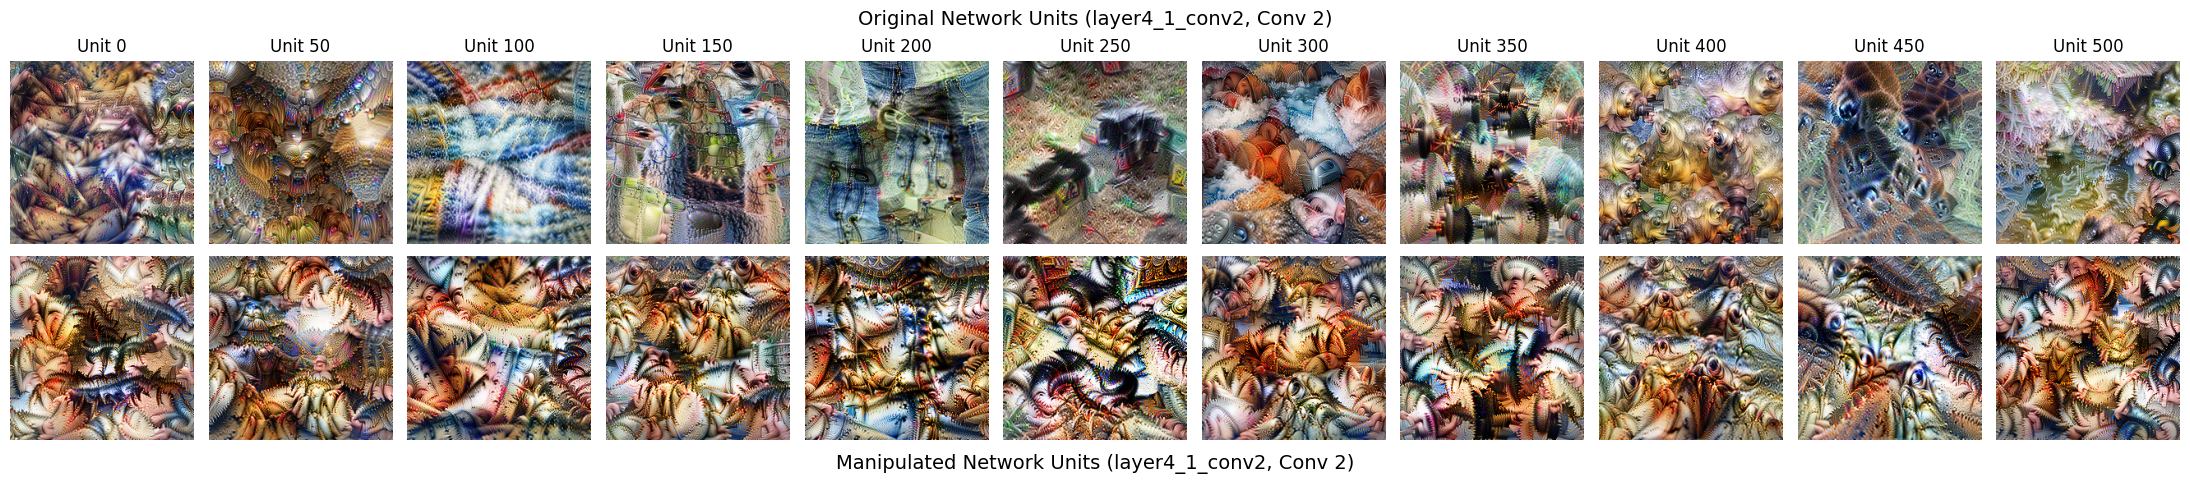

In [12]:
for k in layer_data:
    fig, axs = plt.subplots(2, len(vis))
    scale = 2
    fig.set_size_inches(len(vis) * scale, 2.2 * scale)
    for i, unit_id in enumerate(vis):
        axs[0, i].axis("off")
        axs[1, i].axis("off")

        axs[0, i].set_title(f"Unit {unit_id}")

        axs[0, i].imshow(layer_data[k][0][unit_id][0][0])
        axs[1, i].imshow(layer_data[k][1][unit_id][0][0])

    fig.text(0.5, 1, f"Original Network Units ({k}, Conv 2)", fontsize=14, ha="center")
    fig.text(
        0.5,
        0.025,
        f"Manipulated Network Units ({k}, Conv 2)",
        fontsize=14,
        ha="center",
        va="top",
    )

    plt.tight_layout()
    plt.show()